In [1]:
from block_ai.lib.myblokus import point
from block_ai.lib.myblokus.point import Point
from block_ai.lib.myblokus.piece import Piece
from block_ai.lib.myblokus.corner import Corner
from block_ai.lib.myblokus.orientation import Orientation

import itertools

import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

## Visualization

In [3]:
class PieceVisualization:
    EMPTY = 0
    FULL = 1
    BORDER = 2
    PLAYABLE = 3
    START = 4
    
    def __init__(self):
        pass
    
    def fill(self, point, value):
        x, y = self.get_indices(point)
        self.matrix[x, y] = value
        
    def get_indices(self, point):
        return point.x + 5, point.y + 5
    
    def display(self, orientation):
        self.init_matrix()
        self.fill_in_points(orientation)
        self.gen_graph()

    def init_matrix(self):
        self.x = [str(x) for x in range(-5, 6)]
        self.y = [str(x) for x in range(-5, 6)]
        matrix = []
        for x in self.x:
            sub = [self.EMPTY for y in self.y]
            matrix.append(sub)
        self.matrix = np.matrix(matrix)

    def fill_in_points(self, orientation):
        for p in orientation.points:
            self.fill(p, self.FULL)

        for p in orientation.get_corner_points():
            self.fill(p, self.PLAYABLE)
        
        for p in orientation.get_border_points():
            self.fill(p, self.BORDER)
            
        self.fill(Point(-1, -1), self.START)

    def gen_graph(self):
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.set_aspect('equal')
        plt.imshow(self.matrix, origin='dumb')
        plt.show()

In [128]:
"""
This class defines a Player as a collection of.

Pieces, valid moves, and invalid squares.
"""

from block_ai.lib.myblokus.piece import *
from block_ai.lib.myblokus.point import Point

import logging

class Player:

    def __init__(self, player_num):
        self.player_num = player_num
        self.pieces = gen_pieces()
        self.valid_moves = {}
        self.no_go_squares = []
        
    def update_state(self, move):
        del self.pieces[move.piece_id]
        del self.valid_moves[move.corner]
        self.add_invalid_points(move)
        '''
        for c in self.valid_moves:
            try:
                del self.valid_moves[c][move.piece_id]
            except:
                pass
        self.clear_moves(move)
        '''

    def clear_moves(self, move):


        good_corners = list(self.valid_moves.keys())
        
        for corner in self.valid_moves.keys():
            if corner.p2 in invalid_points:
                good_corners.remove(corner)
                
        self.valid_moves = {c: self.valid_moves[c] for c in good_corners}
        
        for corner in self.valid_moves.keys():
            for old_m in self.get_corner_moves(corner):
                if self.overlap(old_m, move.get_footprint()):
                    self.valid_moves[corner][old_m.piece_id].remove(old_m)

    def add_invalid_points(self, move):
        rot = move.corner.get_rotation()
        invalid_points = [rot(p) for p in move.orientation.get_invalid_points()]
        invalid_points = filter(self.on_board, invalid_points)
        self.no_go_squares += invalid_points

    # TODO unduplicate this 
    def on_board(self, p):
        return p.x not in range(20) or p.y not in range(20)
        
    def is_move_valid(self, move):
        if not self.has_piece(move.piece_id):
            return False
        
        for p in move.orientation.points:
            if p in self.no_go_squares:
                logging.debug("Point: %s in player: %s no go squares", p, self.player_num)
                return False

        return True
        
    def is_orientation_valid(self, orientation):
        for p in orientation.points:
            if p in self.no_go_squares:
                
                return False
        return True
    
    def has_piece(self, piece_id):
        return piece_id in self.pieces
    
    def add_move(self, corner, move):
        try:
            corner_moves = self.valid_moves[corner]
            try:
                corner_moves[move.piece_id].append(move)
            except KeyError:
                corner_moves[move.piece_id] = [move]
        except KeyError:
            self.valid_moves[corner] = {}
            corner_moves = self.valid_moves[corner]
            corner_moves[move.piece_id] = [move]

    def delete_move(self, move):
        self.valid_moves[move.corner][move.piece_id].remove(move)

    def overlap(self, move, footprint):
        # TODO make this faster by sorting and incrementing
        for p in move.get_footprint():
            if p in footprint:
                return True
        return False

    def get_valid_moves(self):
        for corner in self.valid_moves:
            for m in self.get_corner_moves(corner):
                yield m

    def get_corner_moves(self, corner):
        for piece_id in self.valid_moves[corner]:
            for m in self.get_corner_piece_moves(corner, piece_id):
                yield m

    def get_corner_piece_moves(self, corner, piece_id):
        try:
            for m in self.valid_moves[corner][piece_id]:
                yield m
        except:
            pass
            
    def get_piece_moves(self, piece_id):
        for corner in self.valid_moves:
            try:
                for m in self.get_corner_piece_moves(corner, piece_id):
                    yield m
            except KeyError:
                continue

    def has_moves(self):
        return len(self.valid_moves) > 0

class Move:
    
    def __init__(self, orientation, player_id, piece_id, corner):
        self.orientation = orientation
        self.player_id = player_id
        self.piece_id = piece_id
        self.corner = corner

    def get_footprint(self):
        return [p for p in self.orientation.points]
    
    def __repr__(self):
        o_repr = repr(self.orientation)
        c_repr = repr(self.corner)
        return f"""Move(orientation={o_repr},
                        player_id={self.player_id},
                        piece_id='{self.piece_id}',
                        corner={c_repr})"""

    def __str__(self):
        return f"Player ID: {self.player_id}\nPiece ID:{self.piece_id}\n{self.orientation}"

class Board:
    SIDE_LENGTH = 20
    EMPTY = -1

    def __init__(self):
        shape = (self.SIDE_LENGTH, self.SIDE_LENGTH)
        self.board = np.full(shape, self.EMPTY)
        self.player_pointer = 0
        self.players = [Player(i) for i in range(4)]
        self.set_starting_moves()
        self.move_history = []
    
    def set_starting_moves(self):
        logging.info("Starting Moves")
        corners = [Corner(Point(-1, -1), Point(0, 0)),
                   Corner(Point(-1, 20), Point(0, 19)),
                   Corner(Point(20, 20), Point(19, 19)),
                   Corner(Point(20, -1), Point(19, 0))]

        for i, c in enumerate(corners):
            self.add_corner_moves(c, i)

    def make_move(self, move):
        logging.debug("Making move: %s", move)
        if self.is_move_valid(move):
            self.update_state(move)
            self.move_history.append(move)
        else:
            logging.warning("Invalid move: %s", repr(move))

    def update_state(self, move):
        player = self.players[move.player_id]
        player.update_state(move)
        
        for p in move.get_footprint():
            self.assign(p, move.player_id)
            
        for corner in move.orientation.get_corners():
            self.add_corner_moves(corner, move.player_id)
            
        # TODO make this better
        for m in self.get_players_moves(move.player_id):
            if not self.is_move_valid(m):
                player.delete_move(m)

    def add_corner_moves(self, corner, player_id):
        player = self.players[player_id]
        rotation = corner.get_rotation()

        for piece_id, piece in player.pieces.items():
            for orientation in piece.orientations:
                
                new_o = Orientation([corner.p2 + rotation(p) for p in orientation.points])
                m = Move(new_o, player_id, piece_id, corner)

                if self.is_move_valid(m):
                    player.add_move(corner, m)

    def is_move_valid(self, move):
        if not self.are_squares_free(move.orientation):
            logging.debug("Squares no free")
            return False
        
        player = self.players[move.player_id]
        if not player.is_move_valid(move):
            logging.debug("Player invalid")
            return False
        
        return True

    def are_squares_free(self, orientation):
        for p in orientation.points:
            if not self.is_square_free(p):
                return False
        return True

    def is_square_free(self, p):
        if not self.on_board(p):
            return False
        if not self.point_empty(p):
            fill_val = self.check(p)
            return False
        return True

    def on_board(self, point):
        valid_points = range(0, self.SIDE_LENGTH)
        return point.x in valid_points and point.y in valid_points
    
    def point_empty(self, p):
        return self.check(p) == self.EMPTY
    
    def check(self, point):
        return self.board[point.x][point.y]
    
    def get_players_moves(self, player_id):
        return self.players[player_id].get_valid_moves()
    
    def assign(self, point, value):

        self.__assign(point, value, self.board)
        
    def __assign(self, point, value, board):
        if self.on_board(point):
            logging.debug("assigning %s: %s", point, value)
            board[point.y][point.x] = value
        else:
            logging.debug("%s off board not assigning", point)

    def __str__(self):
        return str(self.board)

    def copy(self):
        return eval(repr(self))

    def display(self):
        self.__display(self.board)

    def __display(self, board):
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.set_aspect('equal')
        plt.imshow(board, origin='lower')
        plt.show()

    def show_player_view(self, player_id):
        fill_val = 3
        next_board = self.board.copy()

        for p in self.players[player_id].no_go_squares:
            self.__assign(p, fill_val, next_board)
        self.__display(next_board)
            
def gen_pieces():
    pieces = {
        'p1': Piece([Point(0, 0)]),
        'p2': Piece([Point(0, 0), Point(0, 1)]),
        'p3': Piece([Point(0, 0), Point(0, 1), Point(0, 2)]),
        'p4': Piece([Point(0, 0), Point(0, 1), Point(1, 1)]),
        'p5': Piece([Point(0, 0), Point(1, 0), Point(0, 1), Point(1, 1)]),
        'p6': Piece([Point(0, 0), Point(1, 0), Point(2, 0), Point(3, 0)]),
        'p7': Piece([Point(0, 0), Point(1, 0), Point(1, 1), Point(2, 1)]),
        'p8': Piece([Point(0, 0), Point(1, 0), Point(1, 1), Point(2, 0)]),
        'p9': Piece([Point(0, 0), Point(1, 0), Point(1, 1), Point(2, 1)]),
        'p10': Piece([Point(0, 0), Point(1, 0), Point(2, 0), Point(3, 0), Point(4, 0)]),
        'p11': Piece([Point(0, 0), Point(1, 0), Point(2, 0), Point(3, 0), Point(3, 1)]),
        'p15': Piece([Point(0, 0), Point(1, 0), Point(2, 0), Point(3, 0), Point(2, 1)]),
        'p12': Piece([Point(0, 0), Point(1, 0), Point(2, 0), Point(2, 1), Point(3, 1)]),
        'p17': Piece([Point(0, 0), Point(1, 0), Point(2, 0), Point(2, 1), Point(2, 2)]),
        'p16': Piece([Point(0, 0), Point(1, 0), Point(2, 0), Point(1, 1), Point(1, 2)]),
        'p13': Piece([Point(0, 0), Point(1, 0), Point(2, 0), Point(1, 1), Point(2, 1)]),
        'p18': Piece([Point(0, 0), Point(1, 0), Point(1, 1), Point(2, 1), Point(2, 2)]),
        'p20': Piece([Point(0, 0), Point(1, 0), Point(1, 1), Point(2, 1), Point(1, 2)]),
        'p21': Piece([Point(0, 1), Point(1, 1), Point(1, 2), Point(1, 0), Point(2, 1)]),
        'p14': Piece([Point(0, 0), Point(1, 0), Point(2, 0), Point(0, 1), Point(2, 1)]),
        'p19': Piece([Point(0, 0), Point(0, 1), Point(1, 1), Point(2, 1), Point(2, 2)])
    }
    
    return pieces


In [129]:
board = Board()
for i in range(10):
    m = get_random_move(board, 0)
    board.make_move(m)

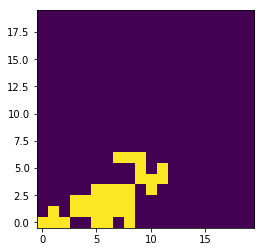

In [130]:
board.display()

In [110]:
moves = board.move_history

What the fuck is this

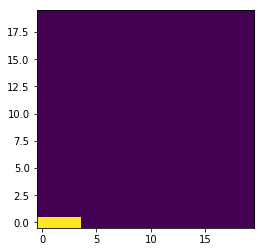

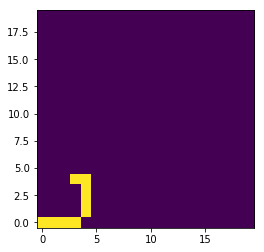

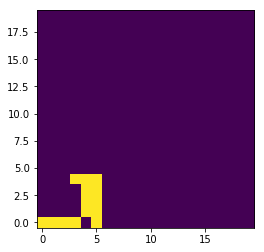

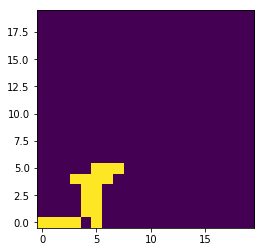

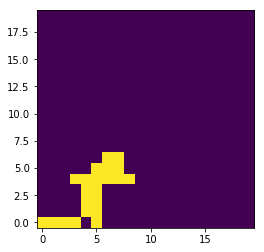

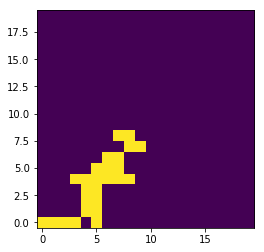

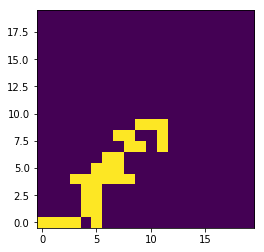

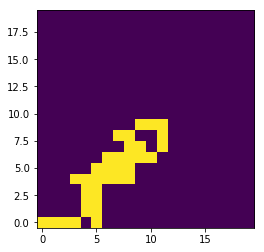

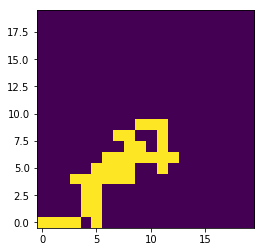

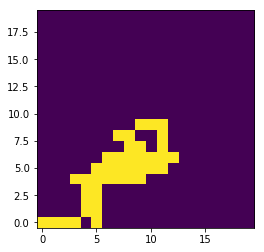

In [111]:
board2 = Board()
for m in moves:
    board2.make_move(m)
    board2.display()

In [113]:
def get_random_move(board, player_id):
    if board.players[player_id].has_moves():        
        moves = list(board.get_players_moves(player_id))
        rand_int = random.randint(0, len(moves))
        return moves[rand_int]
    else:
        raise StopIteration

def replay_game(moves):
    board = Board()
    for move in moves:
        board.make_move(move)
    return board
    
def play_bad_move(moves):
    logger.setLevel(logging.WARNING)
    board = replay_game(moves[:-1])
    board.show_player_view(0)
    logger.setLevel(logging.DEBUG)
    board.make_move(moves[-1])

def play_random_moves():
    player_id = 0
    board = Board()
    while board.players[player_id].has_moves():
        m = get_random_move(board, player_id)
        board.make_move(m)
        board.display()
    return board
    

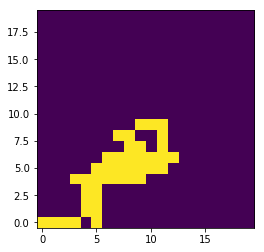

In [117]:
board.show_player_view(0)

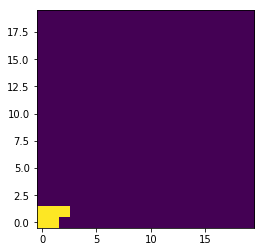

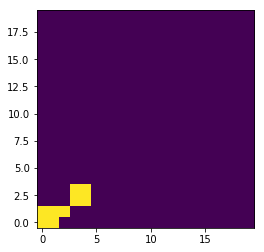

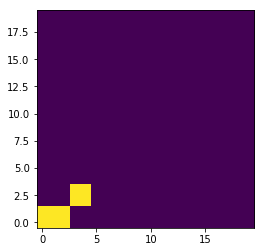

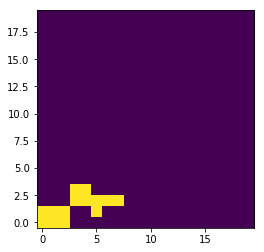

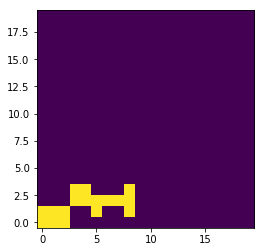

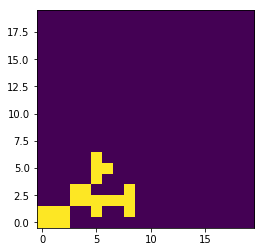

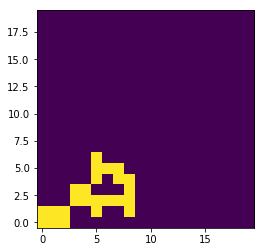

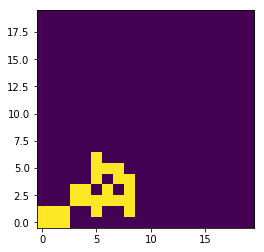

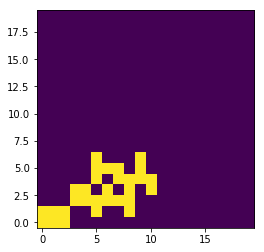

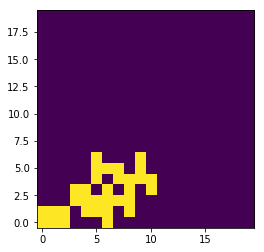

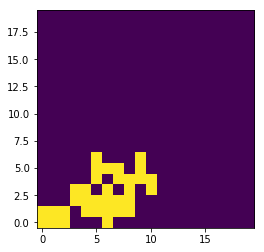

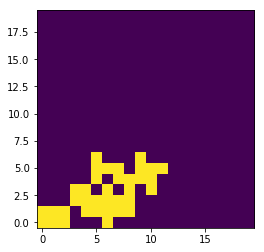

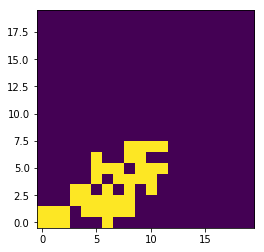

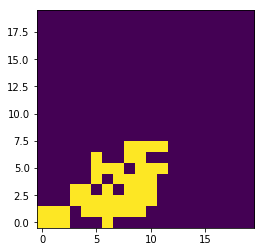

                        player_id=0,
                        piece_id='p21',
                        corner=Corner(p1=Point(6, 1), p2=Point(5, 2)))


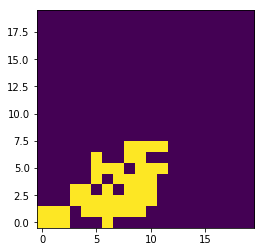

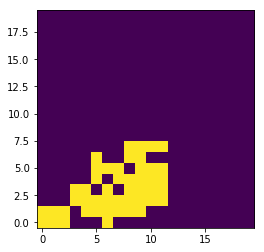

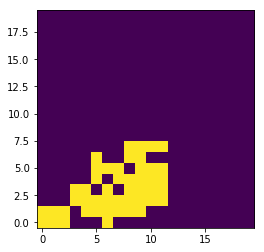

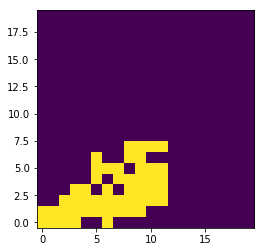

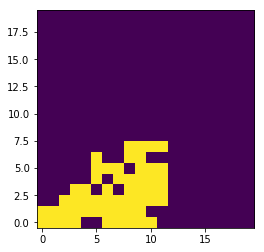

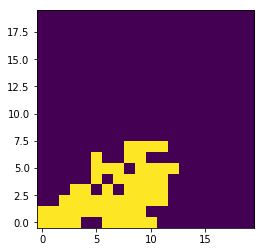

                        player_id=0,
                        piece_id='p16',
                        corner=Corner(p1=Point(10, 2), p2=Point(11, 1)))


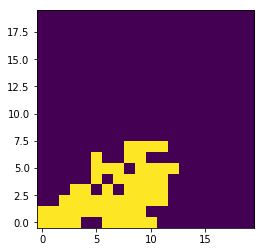

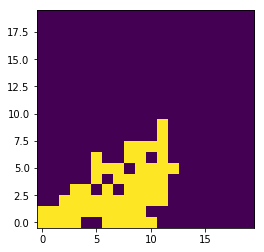

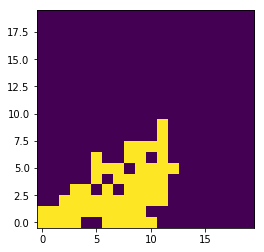

                        player_id=0,
                        piece_id='p17',
                        corner=Corner(p1=Point(12, 5), p2=Point(13, 6)))


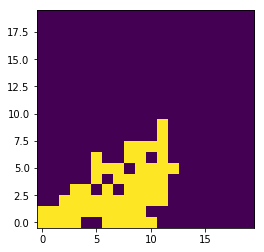

                        player_id=0,
                        piece_id='p17',
                        corner=Corner(p1=Point(8, 3), p2=Point(7, 2)))


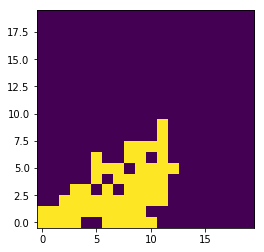

                        player_id=0,
                        piece_id='p17',
                        corner=Corner(p1=Point(8, 3), p2=Point(7, 4)))


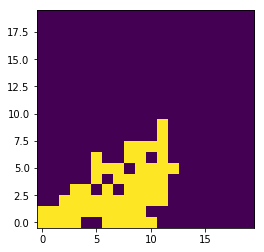

                        player_id=0,
                        piece_id='p17',
                        corner=Corner(p1=Point(10, 3), p2=Point(11, 2)))


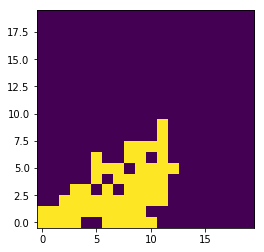

                        player_id=0,
                        piece_id='p17',
                        corner=Corner(p1=Point(10, 4), p2=Point(11, 3)))


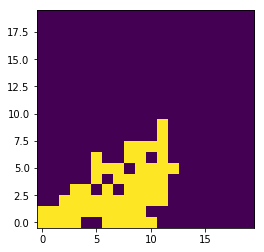

                        player_id=0,
                        piece_id='p17',
                        corner=Corner(p1=Point(11, 4), p2=Point(12, 5)))


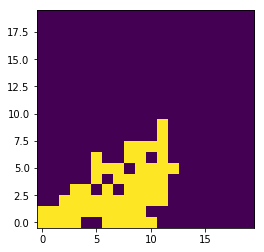

IndexError: list index out of range

In [114]:
board = play_random_moves()

In [115]:
board.move_history

[Move(orientation=Orientation((Point(0, 0), Point(1, 0), Point(2, 0), Point(3, 0))),
                         player_id=0,
                         piece_id='p6',
                         corner=Corner(p1=Point(-1, -1), p2=Point(0, 0))),
 Move(orientation=Orientation((Point(3, 4), Point(4, 1), Point(4, 2), Point(4, 3), Point(4, 4))),
                         player_id=0,
                         piece_id='p11',
                         corner=Corner(p1=Point(3, 0), p2=Point(4, 1))),
 Move(orientation=Orientation((Point(5, 0), Point(5, 1), Point(5, 2), Point(5, 3), Point(5, 4))),
                         player_id=0,
                         piece_id='p10',
                         corner=Corner(p1=Point(4, 1), p2=Point(5, 0))),
 Move(orientation=Orientation((Point(5, 5), Point(6, 4), Point(6, 5), Point(7, 5))),
                         player_id=0,
                         piece_id='p8',
                         corner=Corner(p1=Point(4, 4), p2=Point(5, 5))),
 Move(orientation=Orientat

In [131]:
moves = [Move(orientation=Orientation((Point(0, 0), Point(1, 0), Point(2, 0), Point(3, 0))),
                         player_id=0,
                         piece_id='p6',
                         corner=Corner(p1=Point(-1, -1), p2=Point(0, 0))),
 Move(orientation=Orientation((Point(3, 4), Point(4, 1), Point(4, 2), Point(4, 3), Point(4, 4))),
                         player_id=0,
                         piece_id='p11',
                         corner=Corner(p1=Point(3, 0), p2=Point(4, 1))),
 Move(orientation=Orientation((Point(5, 0), Point(5, 1), Point(5, 2), Point(5, 3), Point(5, 4))),
                         player_id=0,
                         piece_id='p10',
                         corner=Corner(p1=Point(4, 1), p2=Point(5, 0))),
 Move(orientation=Orientation((Point(5, 5), Point(6, 4), Point(6, 5), Point(7, 5))),
                         player_id=0,
                         piece_id='p8',
                         corner=Corner(p1=Point(4, 4), p2=Point(5, 5))),
 Move(orientation=Orientation((Point(6, 6), Point(7, 4), Point(7, 5), Point(7, 6), Point(8, 4))),
                         player_id=0,
                         piece_id='p19',
                         corner=Corner(p1=Point(7, 5), p2=Point(8, 4))),
 Move(orientation=Orientation((Point(7, 8), Point(8, 7), Point(8, 8), Point(9, 7))),
                         player_id=0,
                         piece_id='p9',
                         corner=Corner(p1=Point(7, 6), p2=Point(8, 7))),
 Move(orientation=Orientation((Point(9, 9), Point(10, 9), Point(11, 7), Point(11, 8), Point(11, 9))),
                         player_id=0,
                         piece_id='p17',
                         corner=Corner(p1=Point(8, 8), p2=Point(9, 9))),
 Move(orientation=Orientation((Point(7, 6), Point(8, 5), Point(8, 6), Point(9, 6), Point(10, 6))),
                         player_id=0,
                         piece_id='p15',
                         corner=Corner(p1=Point(9, 7), p2=Point(10, 6))),
 Move(orientation=Orientation((Point(10, 6), Point(11, 5), Point(11, 6), Point(11, 7), Point(12, 6))),
                         player_id=0,
                         piece_id='p21',
                         corner=Corner(p1=Point(11, 7), p2=Point(12, 6))),
 Move(orientation=Orientation((Point(8, 6), Point(9, 4), Point(9, 5), Point(9, 6), Point(10, 5))),
                         player_id=0,
                         piece_id='p20',
                         corner=Corner(p1=Point(8, 5), p2=Point(9, 4)))]

In [40]:
board2 = Board()

In [116]:
board_replay.show_player_view(0)

NameError: name 'board_replay' is not defined

## Status
This code is close to working and is ugly as fuck

#### Questions:

why does it allow invalid moves in the below loop?

Theres an average branching factor of around 25
so call it 75 is that doable?





Number of chess game one guy says with 40 avg moves avg 30 moves per game
~ 10 ** 120 

James Hardy says (10 ** 50) ** 50 

Number of blockus game???

In [3]:
f"{len(str(75 ** (20 * 4)))}"

'151'

14780882941434592331608321020638329760100000000000000000000000000000000000000000000000000000000000000000000000000000000

151